# Customer Segmentation
## Goals:
1. Connect to data
2. SQL show the summary of the data
3. Explore data by Countries and Time Series
4. Cohort Analysis
5. RFM Analysis with KMean

In [386]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter,MonthLocator,YearLocator,MonthLocator,WeekdayLocator
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [387]:
# Query the cleaned data
conn=sqlite3.connect("data/bootcamp_db")

In [388]:
conn

In [389]:
# Show the table name from database
sql_query = """SELECT name 
               FROM sqlite_master 
               WHERE type='table';"""

cursor = conn.cursor()

# executing our sql query
cursor.execute(sql_query)

 
# printing all tables list
print(f"List of tables in the database:\n{cursor.fetchall()}")

List of tables in the database:
[('online_transactions',), ('stock_description',), ('online_transactions_cleaned',)]


In [390]:
# load all the information from the table
query="""
      SELECT *
      FROM online_transactions_cleaned ;
      """

original=pd.read_sql(query,conn)

In [391]:
len(original)

399807

# 1. Data Summary

In [392]:
# The general information
query="""
      SELECT COUNT(DISTINCT customer_id) AS number_customers,
             COUNT(DISTINCT invoice) AS number_orders,
             MIN(invoice_date) AS first_purchase,
             MAX(invoice_date) AS last_purchase,
             AVG(total_order_value) AS average_order_value,
             COUNT(DISTINCT country) AS number_country,
             COUNT(DISTINCT stock_code) AS number_distinct_items,
             COUNT(DISTINCT description) AS number_description,
             COUNT(DISTINCT substr(invoice_date,1,4)) AS number_years,
             COUNT(DISTINCT substr(invoice_date,1,7)) AS number_months,
             COUNT(CASE WHEN description='UNKNOWN' THEN 1 ELSE Null END) AS number_unknown_description
      FROM online_transactions_cleaned
      """
pd.read_sql(query,conn)

,number_customers,number_orders,first_purchase,last_purchase,average_order_value,number_country,number_distinct_items,number_description,number_years,number_months,number_unknown_description
0,4362,21788,2010-12-01 08:26:00,2011-12-09 12:50:00,20.718665,37,3679,3644,2,13,1172


# 2. Canceling orders

## 2.1 Identify and Match Canceled Orders

In [393]:
original[original['quantity']<=0].shape[0]

8507

In [394]:
# Find the negative oders
returns = original[original['quantity'] <= 0]

In [395]:
returns.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,total_order_value,description
14,C536391,22557,-12,2010-12-01 10:24:00,1.65,u17548,United Kingdom,-19.80,PLASTERS IN TIN VINTAGE PAISLEY
157,C536548,22631,-1,2010-12-01 14:33:00,1.95,u12472,Germany,-1.95,CIRCUS PARADE LUNCH BOX
227,C536391,21980,-24,2010-12-01 10:24:00,0.29,u17548,United Kingdom,-6.96,PACK OF 12 RED RETROSPOT TISSUES
408,C536820,22878,-1,2010-12-02 17:14:00,2.10,u18168,United Kingdom,-2.10,UNKNOWN
484,C536391,22553,-24,2010-12-01 10:24:00,1.65,u17548,United Kingdom,-39.60,PLASTERS IN TIN SKULLS


In [396]:
# Match the canceled orders and their original orders
merged = original.merge(returns, on=['customer_id','stock_code'], suffixes=('', '_return'))

In [397]:
merged.shape

(34627, 16)

In [398]:
merged.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,total_order_value,description,invoice_return,quantity_return,invoice_date_return,price_return,country_return,total_order_value_return,description_return
0,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.3,WOODEN FRAME ANTIQUE WHITE,C543611,-2,2011-02-10 14:38:00,2.55,United Kingdom,-5.1,WOODEN FRAME ANTIQUE WHITE
1,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.3,WOODEN FRAME ANTIQUE WHITE,C543611,-12,2011-02-10 14:38:00,2.55,United Kingdom,-30.6,WOODEN FRAME ANTIQUE WHITE
2,536396,82494L,12,2010-12-01 10:51:00,2.55,u1785,United Kingdom,30.6,WOODEN FRAME ANTIQUE WHITE,C543611,-2,2011-02-10 14:38:00,2.55,United Kingdom,-5.1,WOODEN FRAME ANTIQUE WHITE
3,536396,82494L,12,2010-12-01 10:51:00,2.55,u1785,United Kingdom,30.6,WOODEN FRAME ANTIQUE WHITE,C543611,-12,2011-02-10 14:38:00,2.55,United Kingdom,-30.6,WOODEN FRAME ANTIQUE WHITE
4,536609,82494L,6,2010-12-02 09:41:00,2.55,u1785,United Kingdom,15.3,WOODEN FRAME ANTIQUE WHITE,C543611,-2,2011-02-10 14:38:00,2.55,United Kingdom,-5.1,WOODEN FRAME ANTIQUE WHITE


In [399]:
# Calculate the total purchase quantity and the total return quantity
merged['total_quantity'] = merged['quantity'] + merged['quantity_return']

## 2.2 Filter and Refine Data

In [400]:
# Find the canceled orders and their original orders
complete_returns = merged[merged['total_quantity'] == 0]

In [401]:
complete_returns.shape[0]

5631

In [402]:
# Ensure that 'complete_returns' contains only the fields that need to be matched
complete_returns = complete_returns[[
    'invoice', 'stock_code', 'description', 'invoice_date', 
    'price', 'quantity', 'total_order_value', 'customer_id', 'country']]

In [403]:
# Remove these records from the original data
original = original.merge(complete_returns, on=[
    'invoice', 'stock_code', 'description', 'invoice_date', 
    'price', 'quantity', 'total_order_value', 'customer_id', 'country'
], how='left', indicator=True)

## 2.3 Clean Up Data

In [404]:
# Keep only the rows that are not marked for deletion
original = original[original['_merge'] == 'left_only']

In [405]:
# Remove auxiliary columns
original = original.drop(columns=['_merge'])

In [406]:
original.shape

(394503, 9)

In [407]:
# Drop the other negative orders
original = original[original['quantity'] > 0]

In [408]:
len(original)

385996

#### Notation
- "returns" is the DataFrame that has all the canceled orders; "complete_returns" is the original order table for canceled orders. 

- "original" is now without canceled orders and their original orders

# 3. Exploring Data

## 3.1 Countries

In [409]:
# 3.1.1 Top 10 most popular and least popular countries
# Top 10 most popular geographical location by invoice
original["country"].value_counts().nlargest(n=10)

country
United Kingdom    344515
Germany             8546
France              7901
EIRE                6841
Spain               2388
Netherlands         2312
Belgium             1928
Switzerland         1801
Portugal            1410
Australia           1108
Name: count, dtype: int64

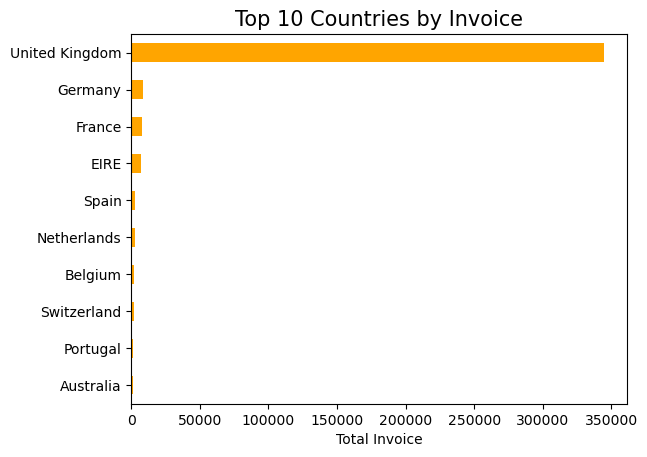

In [410]:
# Visualising the Top 10 populer country by invoice
original["country"].value_counts().head(10).sort_values(ascending=True).plot(kind='barh',color='orange')
plt.title("Top 10 Countries by Invoice",size=15)
plt.ylabel('') 
plt.xlabel("Total Invoice")
plt.show()

In [411]:
# 10 least popular geographical location by invoice
original['country'].value_counts().nsmallest(n=10)

country
Saudi Arabia             9
Bahrain                 17
Czech Republic          23
Brazil                  32
Lithuania               35
Lebanon                 45
European Community      57
RSA                     57
United Arab Emirates    67
USA                     67
Name: count, dtype: int64

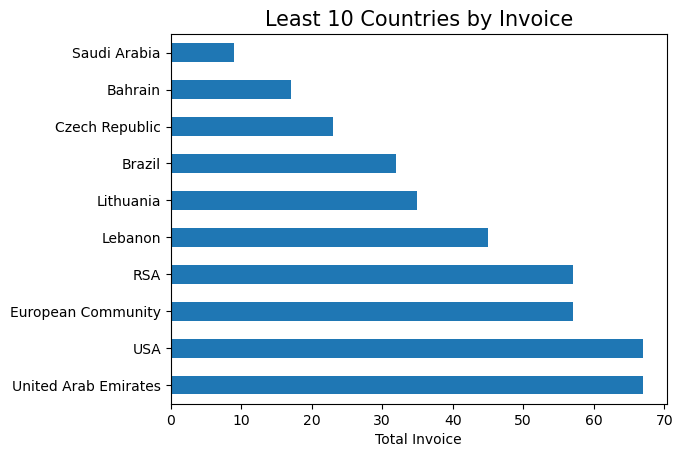

In [412]:
# Visualising the lowest 10 countrie by invoice
original['country'].value_counts().nsmallest(n=10).sort_values(ascending=False).plot(kind='barh')
plt.title("Least 10 Countries by Invoice",size=15)
plt.ylabel('') 
plt.xlabel("Total Invoice")
plt.show()

In [413]:
# 3.1.2 Top 10 most popular and least popular countries by quantity
# Top 10 most popular geographical location by quantity
original.groupby("country")[["quantity"]].sum().sort_values("quantity",ascending=False).head(10)

,quantity
country,
United Kingdom,3972182
Netherlands,199070
EIRE,131292
Germany,116958
France,108375
Australia,83383
Sweden,35283
Switzerland,29637
Spain,26624


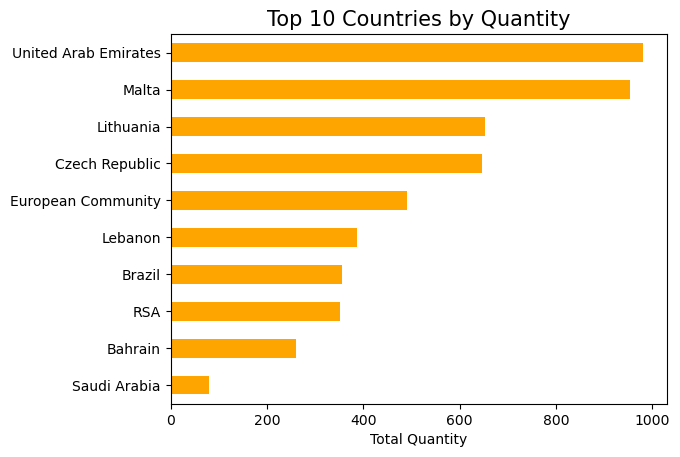

In [414]:
# Visualising the Top 10 populer country by quantity
original.groupby("country")["quantity"].sum().sort_values(ascending=True).head(10).plot(kind='barh',color='orange')
plt.title("Top 10 Countries by Quantity",size=15)
plt.ylabel('') 
plt.xlabel("Total Quantity")
plt.show()

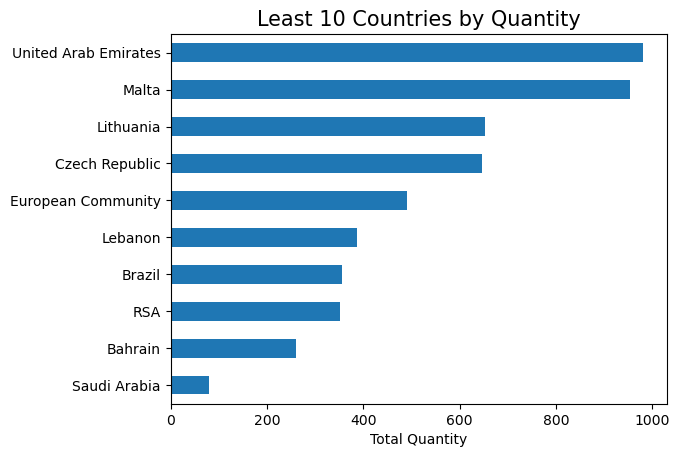

In [415]:
# Top 10 least popular geographical location by quantity
original.groupby('country')['quantity'].sum().sort_values(ascending=False).nsmallest(n=10).plot(kind='barh')
plt.title("Least 10 Countries by Quantity",size=15)
plt.xlabel("Total Quantity")
plt.ylabel('') 
plt.show()

In [416]:
# 3.1.3 Distribution of sales density and shape 
countries=original['country'].unique()

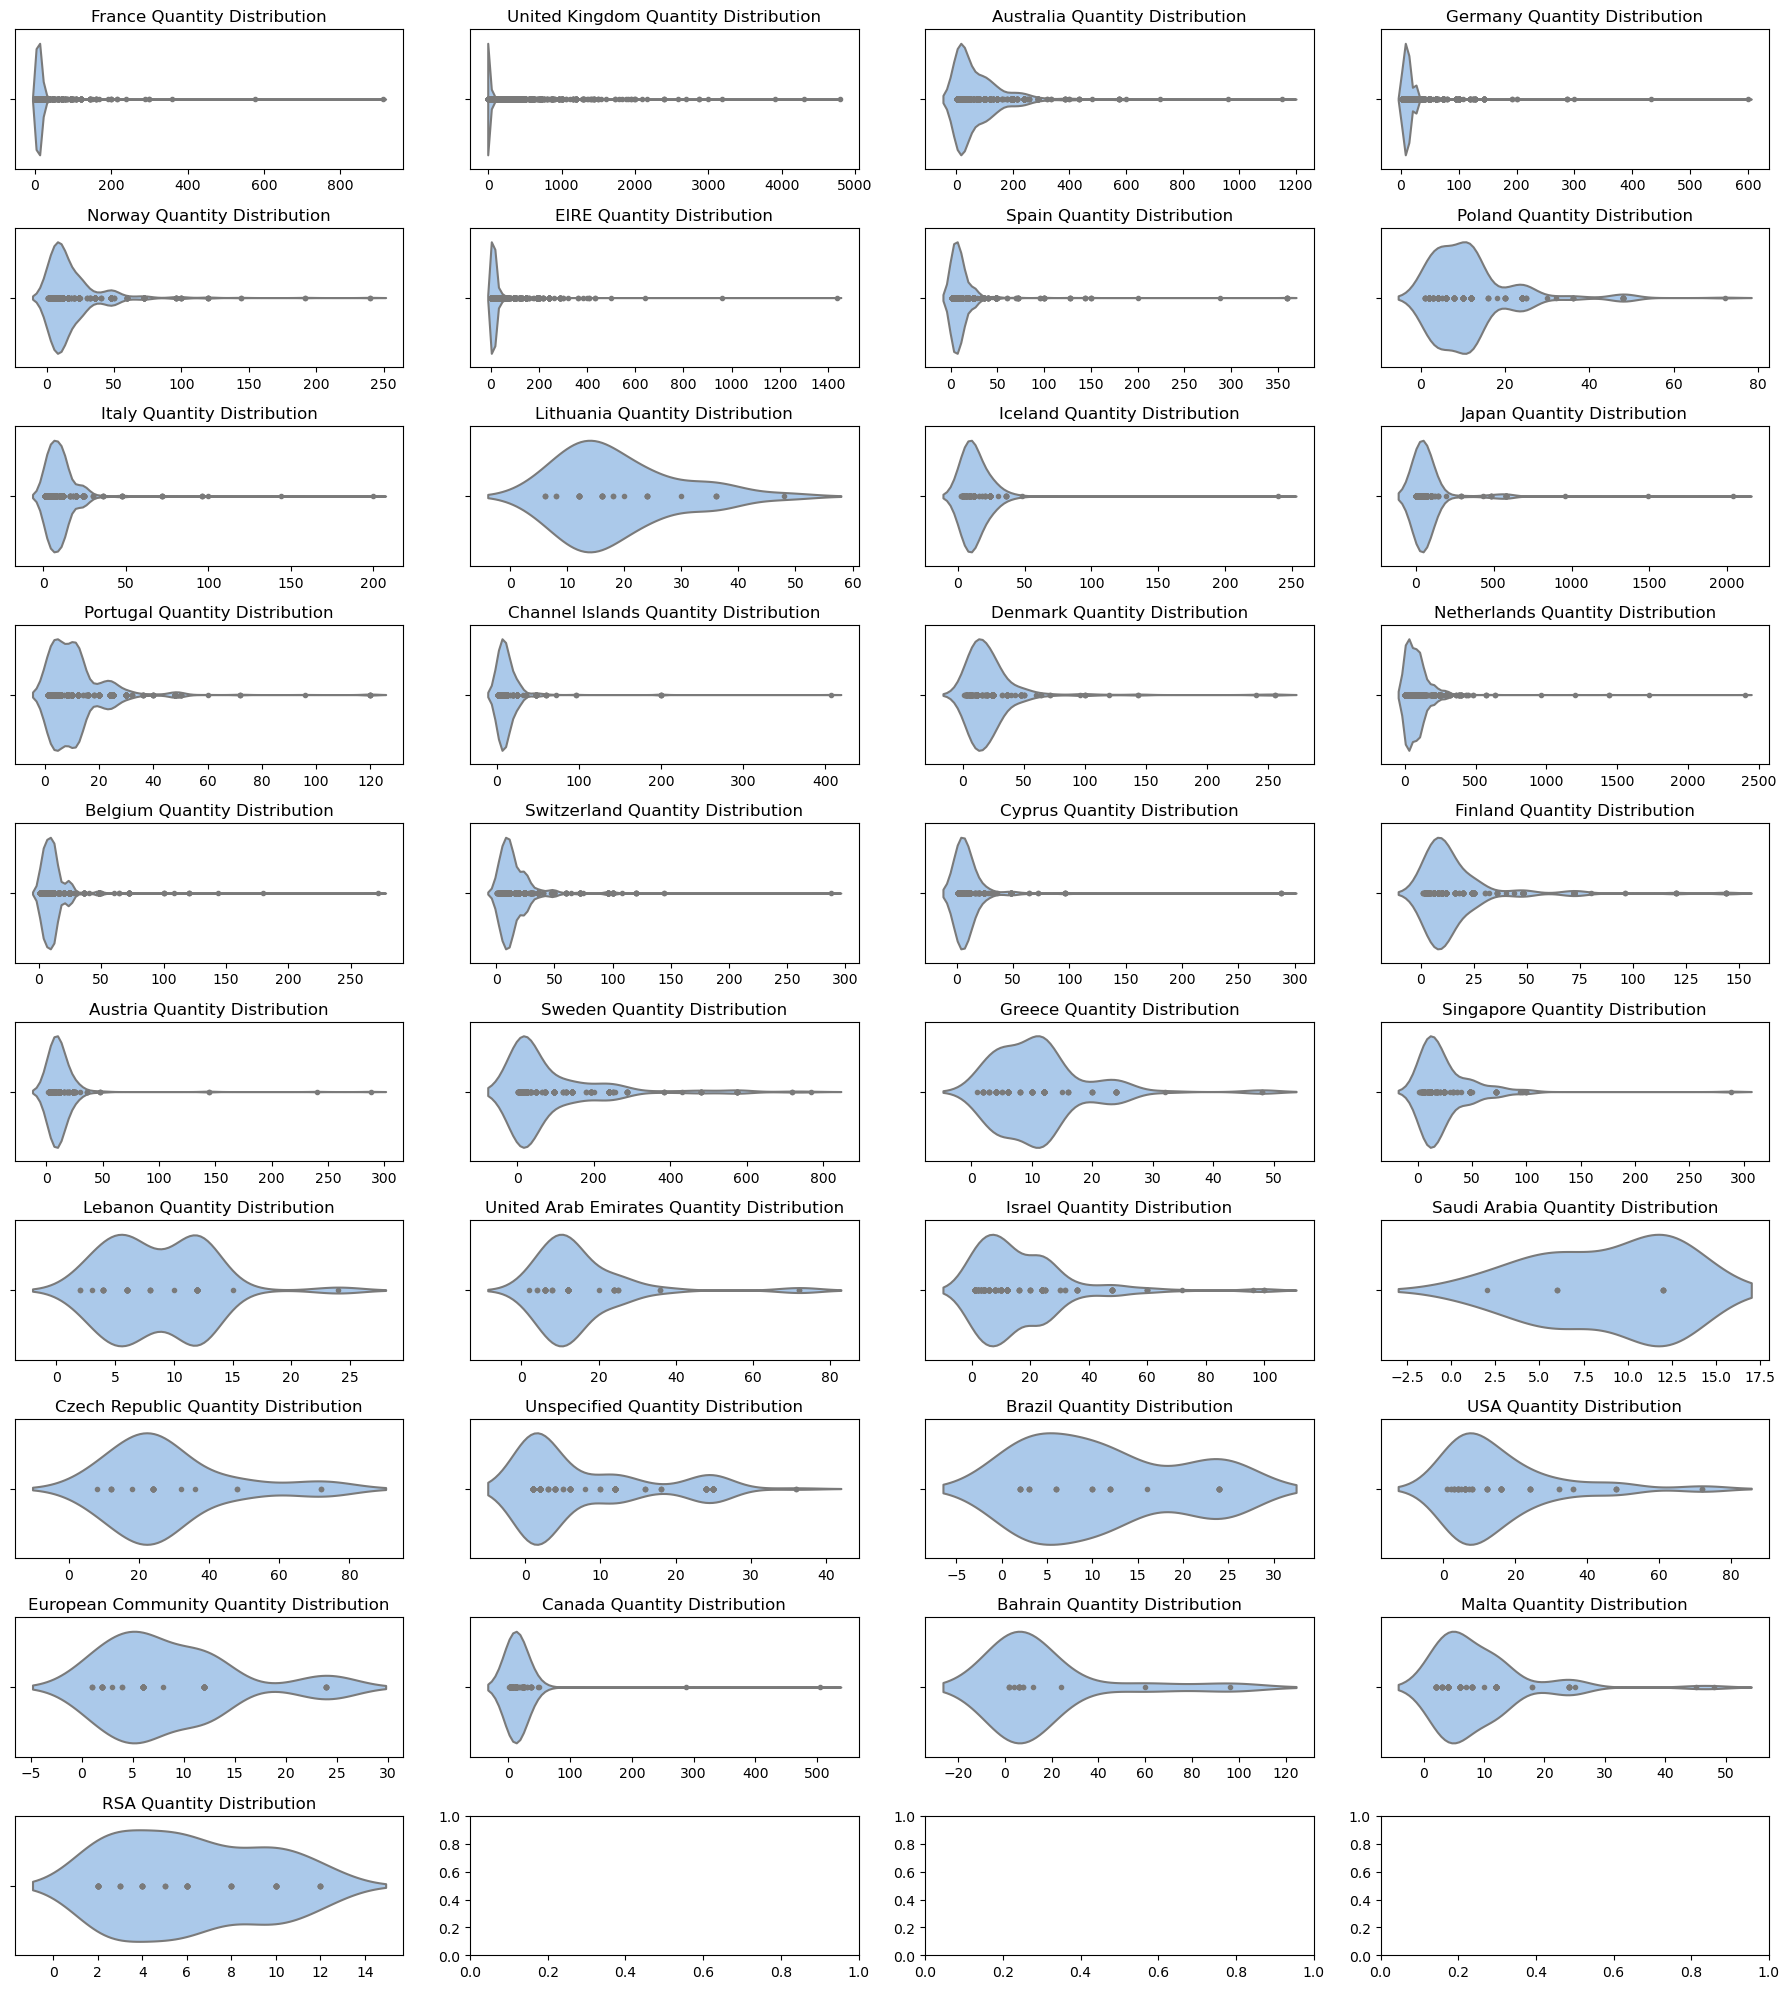

In [417]:
# Create a figure object and subplots
fig,ax=plt.subplots(10,4,figsize=(18,20))
axes_=[axes_row for axes in ax for axes_row in axes]

# Plot the distribution of sales for each country
for i,c in enumerate(countries):
    sns.violinplot(x='quantity',data=original[original['country']==c],ax=axes_[i],inner='point',palette='pastel')
    axes_[i].set_title(c+' '+'Quantity Distribution')
    axes_[i].set_xlabel('')
    axes_[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [418]:
# 3.1.4 Distribution of order price
# Top 10 most popular countries by sum price of order
original.groupby('country')[['price']].sum().sort_values("price",ascending=False).head(10)

,price
country,
United Kingdom,989934.933
EIRE,23175.800
Germany,23014.600
France,20994.330
Spain,7572.460
Belgium,5838.500
Netherlands,5672.380
Switzerland,5146.940
Portugal,3598.040


In [419]:
# Top 10 most popular countries by average price of order
original.groupby('country')['price'].mean().sort_values(ascending=False).head(10)

country
Lebanon               5.387556
Cyprus                5.189983
Bahrain               4.644118
Brazil                4.456250
RSA                   4.352632
European Community    4.242105
Channel Islands       4.148794
Singapore             3.679488
Israel                3.667714
Greece                3.649930
Name: price, dtype: float64

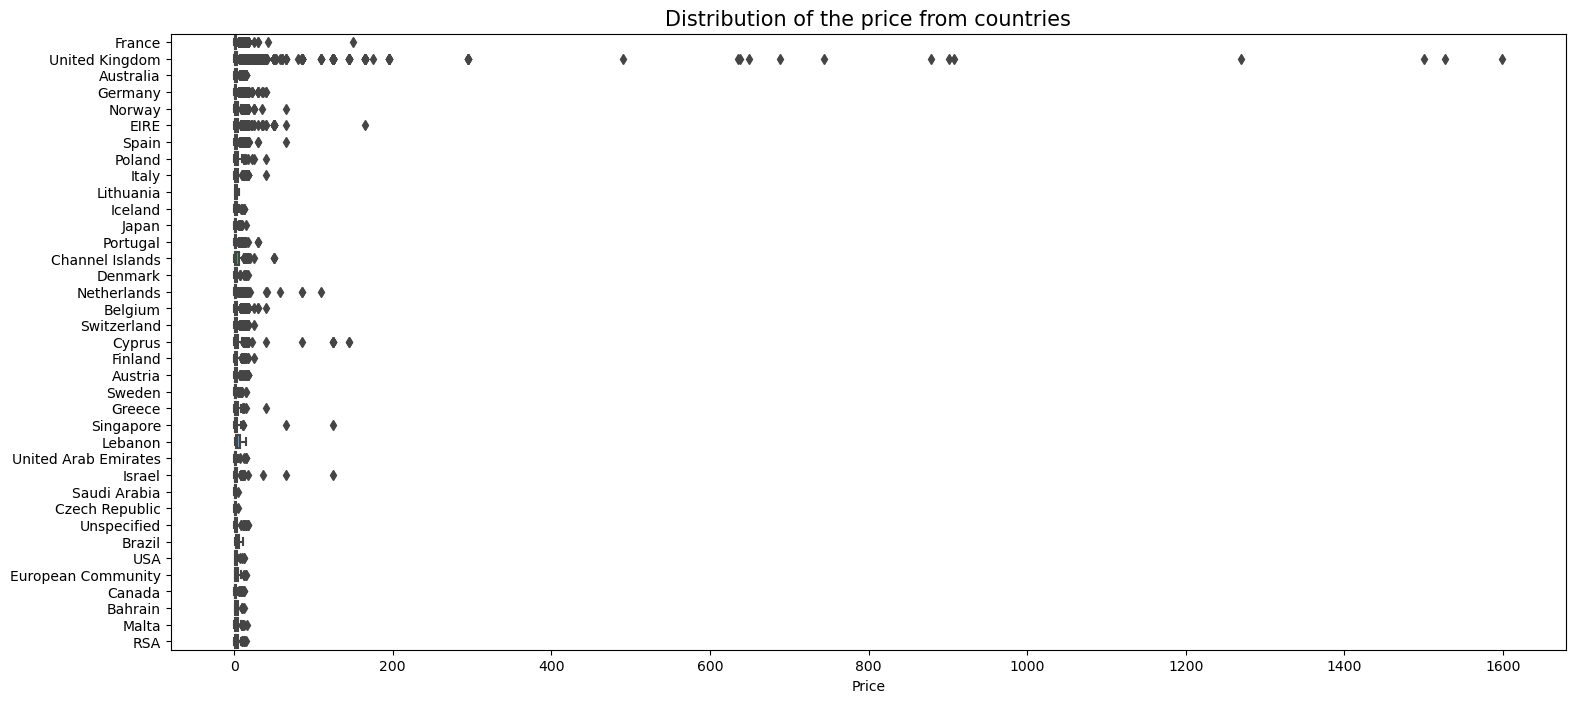

In [420]:
# Distribution of all the countries price 
plt.figure(figsize=(18,8))

sns.boxplot(y='country',x='price',data=original)
plt.title("Distribution of the price from countries",size=15)
plt.xlabel("Price")
plt.ylabel('') 
plt.show()

In [421]:
# Check the United Kindom data 
UK_data=original[original.country=='United Kingdom']

<Axes: xlabel='price'>

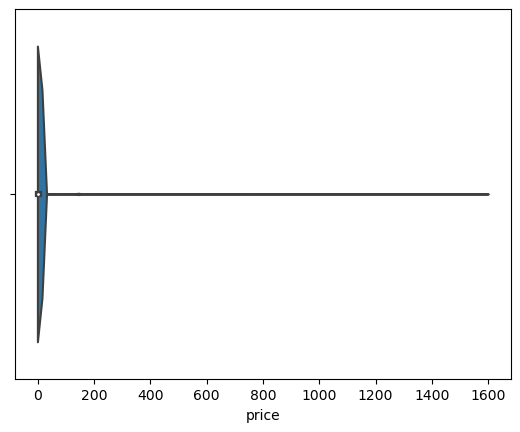

In [422]:
# Plot price from UK
sns.violinplot(x=UK_data['price'])

In [423]:
# Distribution of UK
original[original.country=='United Kingdom']['price'].describe()

count    344515.000000
mean          2.873416
std           7.374809
min           0.001000
25%           1.250000
50%           1.850000
75%           3.750000
max        1599.260000
Name: price, dtype: float64

In [424]:
# 3.1.5 Sales Density by Country
# Extract data
country_plotly=original.groupby('country')[['total_order_value']].sum().reset_index().sort_values('total_order_value',ascending=False)

In [425]:
# Check the result
country_plotly.head()

,country,total_order_value
35,United Kingdom,6756342.413
23,Netherlands,282161.940
10,EIRE,237641.810
14,Germany,203089.880
13,France,181031.390


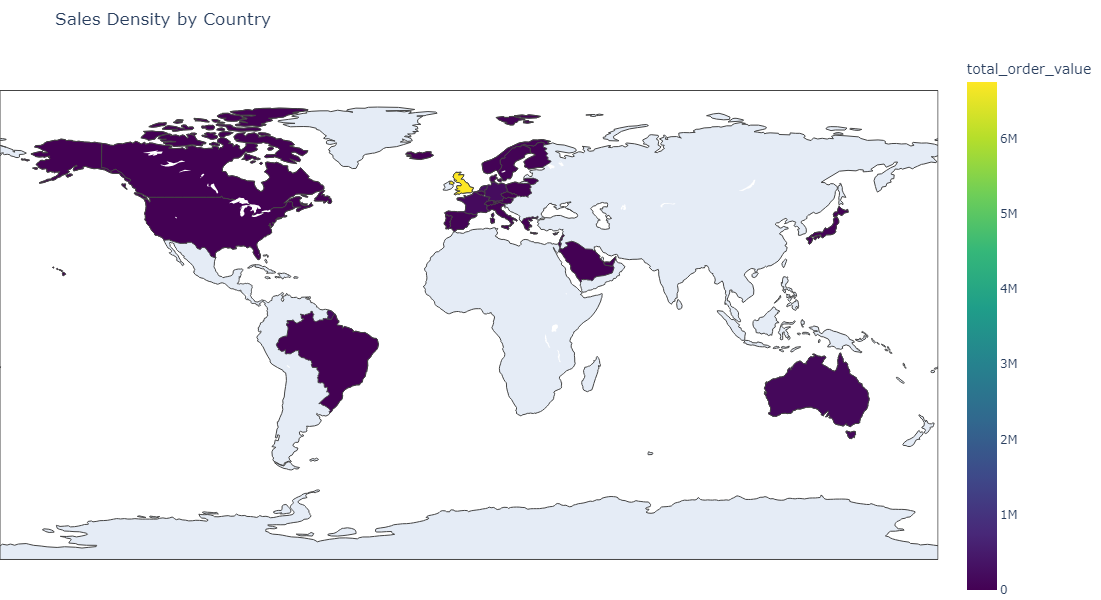

In [426]:
# Create the geographical heatmap
fig = px.choropleth(country_plotly, 
                    locations='country',
                    locationmode='country names',  # Change to 'country names' if using country names
                    color='total_order_value',
                    color_continuous_scale='Viridis',
                    title='Sales Density by Country')

# Adjust the layout to make the map larger
fig.update_layout(
    autosize=True,
    margin=dict(l=0, r=0, t=50, b=0),  # Adjust margins as needed
    height=600,  # Set height to make the map larger
    width=1000    # Set width to make the map larger
)
# Show the figure
fig.show()

#### Notation:
- United Kingdom has the highest price but the average is very low.
- There are some unspecified countries

## 3.2 Time Series Analysis

In [427]:
# 3.2.1 Year
# 3.2.1.1 Distribution of quantity per year
# Change the type of invoice_date
original['invoice_date']=pd.to_datetime(original['invoice_date'])

In [428]:
original['invoice_date'].info()

<class 'pandas.core.series.Series'>
Index: 385996 entries, 0 to 400133
Series name: invoice_date
Non-Null Count   Dtype         
--------------   -----         
385996 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 5.9 MB


In [429]:
# Extract the year from invoice date
original['year']=original['invoice_date'].dt.year

In [430]:
# Total quantity per year
quantity_year=original.groupby('year')[['quantity']].sum().reset_index().sort_values(['year'],ascending=False)

In [431]:
quantity_year

,year,quantity
1,2011,4556889
0,2010,304896


Text(0, 0.5, 'Total Quantity')

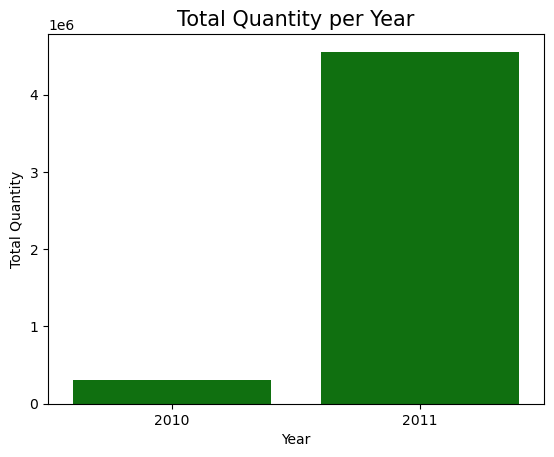

In [432]:
# Total quantity per year
sns.barplot(x='year',y='quantity',data=quantity_year,color='green')
plt.title('Total Quantity per Year',size=15)
plt.xlabel('Year')
plt.ylabel('Total Quantity')


In [433]:
# 3.2.1.2 Distribution total customer per year
# Group by year and customer_id, and calculate the number of unique customer_id for each year
unique_customers_per_year = original.groupby('year')['customer_id'].nunique().reset_index()

In [434]:
unique_customers_per_year

,year,customer_id
0,2010,882
1,2011,4200


<Axes: xlabel='year', ylabel='customer_id'>

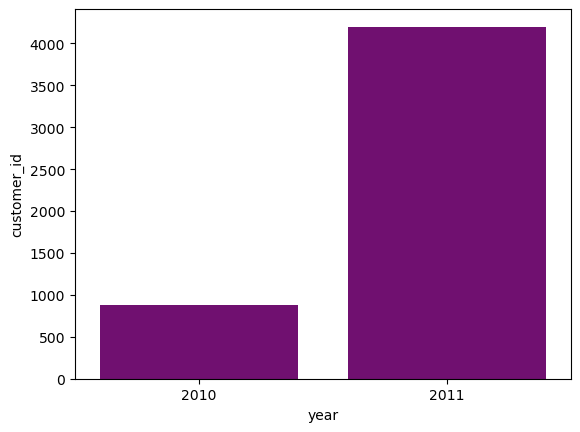

In [435]:
# Show the unique customers per year
sns.barplot(x='year',y='customer_id',data=unique_customers_per_year,color='purple')

In [436]:
# 3.2.2 Month
# 3.2.2.1 Total quantity per month
# Extract month from invoice date
original['month']=original['invoice_date'].dt.month

In [437]:
original.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,total_order_value,description,year,month
0,536370,21791,24,2010-12-01 08:45:00,1.25,u12583,France,30.00,VINTAGE HEADS AND TAILS CARD GAME,2010,12
1,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.30,WOODEN FRAME ANTIQUE WHITE,2010,12
2,536378,21929,10,2010-12-01 09:37:00,1.95,u14688,United Kingdom,19.50,JUMBO BAG PINK VINTAGE PAISLEY,2010,12
3,536381,37444A,1,2010-12-01 09:41:00,2.95,u15311,United Kingdom,2.95,YELLOW BREAKFAST CUP AND SAUCER,2010,12
4,536381,15056BL,2,2010-12-01 09:41:00,5.95,u15311,United Kingdom,11.90,EDWARDIAN PARASOL BLACK,2010,12


In [438]:
# Group by month in 2011 and calculate the total transactions
data_2011=original[original['year']==2011]

In [439]:
# Calculate the total quantity per month
quantity_by_month_2011=data_2011.groupby('month')[['quantity']].sum()

In [440]:
# Reset the index to convert month from an index to a column
quantity_by_month_2011=quantity_by_month_2011.sort_values(['quantity'],ascending=False).reset_index()

In [441]:
quantity_by_month_2011

,month,quantity
0,11,647645
1,10,558213
2,9,536032
3,8,389244
4,5,366561
5,7,359967
6,6,353410
7,3,340292
8,4,280127
9,2,262094


In [442]:
# Group by month in 2010 and calculate the total sum of total_order_value
data_2010=original[original['year']==2010]

In [443]:
quantity_by_month_2010=data_2010.groupby('month')[['quantity']].sum()

In [444]:
quantity_by_month_2010=quantity_by_month_2010.reset_index()

In [445]:
quantity_by_month_2010

,month,quantity
0,12,304896


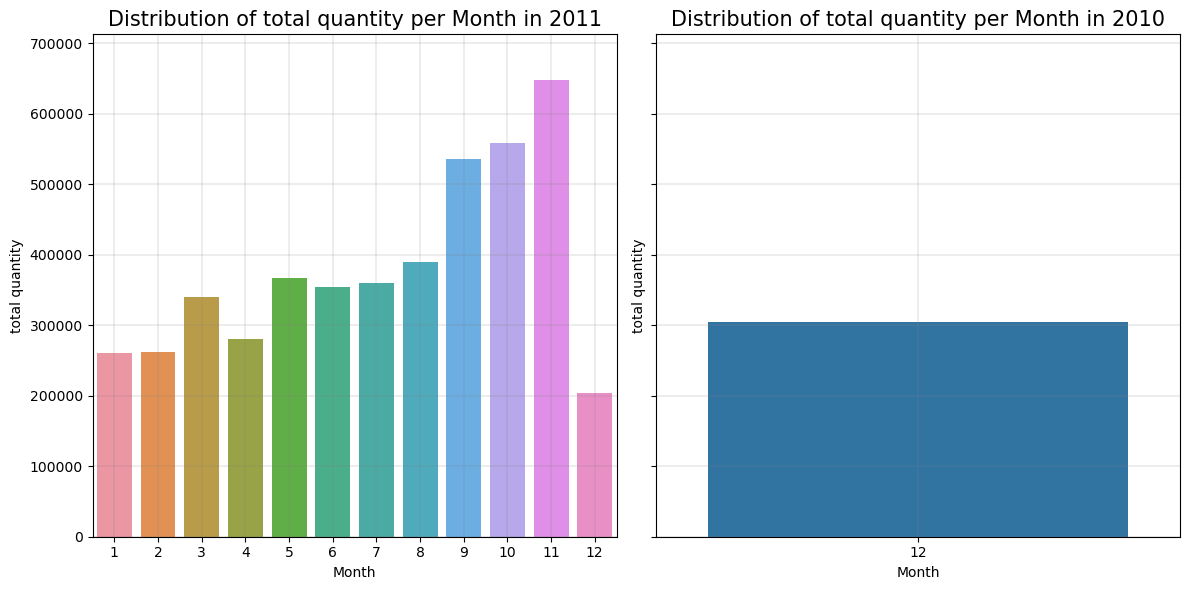

In [446]:
# Create the canvas and subplots, ensuring each subplot is of the same size
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6),sharey=True)

# First subplot: Distribution of invoices per month in 2011.
sns.barplot(x='month',y='quantity',data=quantity_by_month_2011,ax=ax1)
ax1.set_title("Distribution of total quantity per Month in 2011",size=15)
ax1.set_xlabel("Month")
ax1.set_ylabel("total quantity")
ax1.grid(color='gray',linestyle='-',linewidth=0.2)

# Set the Y-axis range for the first subplot
ax1.set_ylim(0, max(quantity_by_month_2011['quantity']) * 1.1)

# Second subplot: Distribution of invoices per month in 2010
sns.barplot(x='month',y='quantity',data=quantity_by_month_2010,ax=ax2)
ax2.set_title("Distribution of total quantity per Month in 2010",size=15)
ax2.set_xlabel("Month")
ax2.set_ylabel("total quantity")
ax2.grid(color='gray',linestyle='-',linewidth=0.2)

# Set the Y-axis range for the second subplot, using the maximum value from the first subplot as a reference
ax2.set_ylim(0, max(quantity_by_month_2011['quantity']) * 1.1)

# Adjust the layout of the subplots
plt.tight_layout()

In [447]:
print(f'The highest number of transactions is the month:',quantity_by_month_2011.iloc[0,0])

The highest number of transactions is the month: 11


In [448]:
# 3.2.2.2 Total customers per month
# Aggregate the month wich customer id
unique_customers_per_month = original.groupby('month')[['customer_id']].nunique().reset_index()

In [449]:
# Check the result
unique_customers_per_month

,month,customer_id
0,1,733
1,2,753
2,3,968
3,4,846
4,5,1050
5,6,982
6,7,942
7,8,930
8,9,1250
9,10,1353


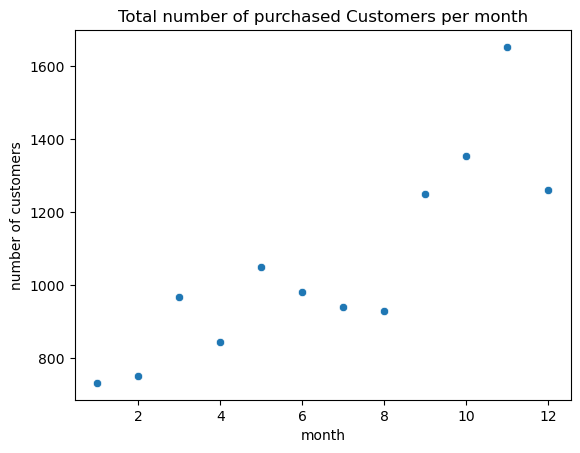

In [450]:
# plot the distribution
sns.scatterplot(x='month',y='customer_id',data=unique_customers_per_month)
plt.title('Total number of purchased Customers per month')
plt.xlabel('month')
plt.ylabel('number of customers')
plt.show()

In [451]:
# 3.2.2.3 Total invoice per month
invoice_per_month=original.groupby('month')[['invoice']].nunique().reset_index()

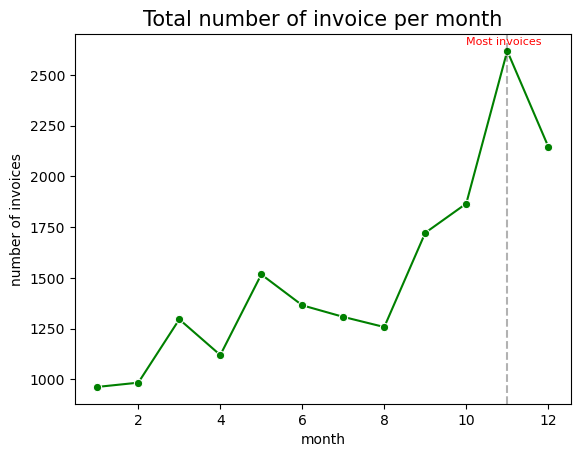

In [452]:
# Distribution number of invoice per month
sns.lineplot(x='month',y='invoice',data=invoice_per_month,marker='o',color='green')

plt.title('Total number of invoice per month',fontsize=15)
plt.xlabel('month')
plt.ylabel('number of invoices')
plt.axvline(11, color = "k", linestyle = '--', alpha = 0.3)

# Adjust the text position and ensure it is within the chart range
plt.text(10, 2650, "Most invoices", size=8, color='red')

plt.show()

In [453]:
# 3.2.3 Week
# 3.2.3.1 Total Transactions by Weekday
# Create a dictionary that maps numbers to the abbreviations of weekdays
weekday_map = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun'
}

In [454]:
# Map the dictionary
original['weekday']=original['invoice_date'].dt.weekday.map(weekday_map)

In [455]:
# Quantity per weekday
weekday_counts = original.groupby('weekday')['quantity'].sum()

In [456]:
# Create a list containing all the days of the week
all_weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [457]:
# If there is no data for a particular day, fill it with 0
counts = [weekday_counts.get(day, 0) for day in all_weekdays]

Text(0, 0.5, 'Count')

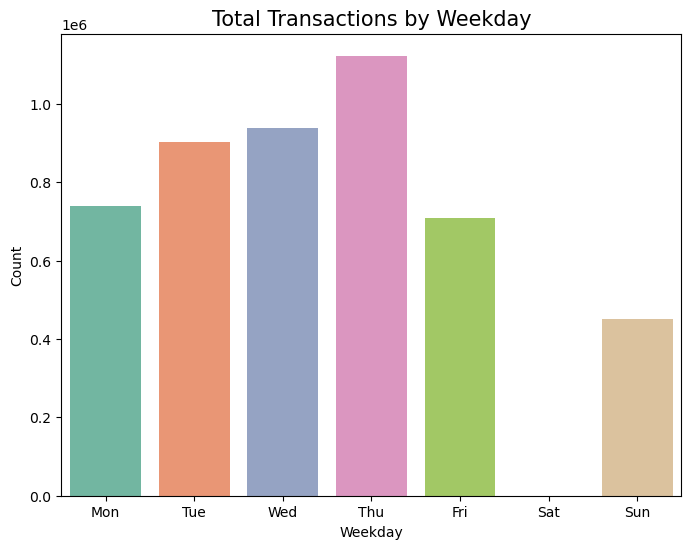

In [458]:
# Distribution of transactions per weekday
plt.figure(figsize=(8, 6))
sns.barplot(x=all_weekdays, y=counts,palette='Set2')
plt.title('Total Transactions by Weekday',size=15)
plt.xlabel('Weekday')
plt.ylabel('Count')

In [459]:
# 3.2.4 Day
# 3.2.4.1 Total Transactions per Day
# Extract day from invoice date
original['day']=original['invoice_date'].dt.day

In [460]:
original.head(3)

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,total_order_value,description,year,month,weekday,day
0,536370,21791,24,2010-12-01 08:45:00,1.25,u12583,France,30.0,VINTAGE HEADS AND TAILS CARD GAME,2010,12,Wed,1
1,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.3,WOODEN FRAME ANTIQUE WHITE,2010,12,Wed,1
2,536378,21929,10,2010-12-01 09:37:00,1.95,u14688,United Kingdom,19.5,JUMBO BAG PINK VINTAGE PAISLEY,2010,12,Wed,1


In [461]:
# Quantity per weekday
day_quantity = original.groupby('day')[['quantity']].sum().reset_index()

In [462]:
day_quantity

,day,quantity
0,1,166948
1,2,149227
2,3,143389
3,4,186533
4,5,211612
5,6,192029
6,7,195332
7,8,170948
8,9,162605
9,10,159751


Text(0, 0.5, 'Quantity')

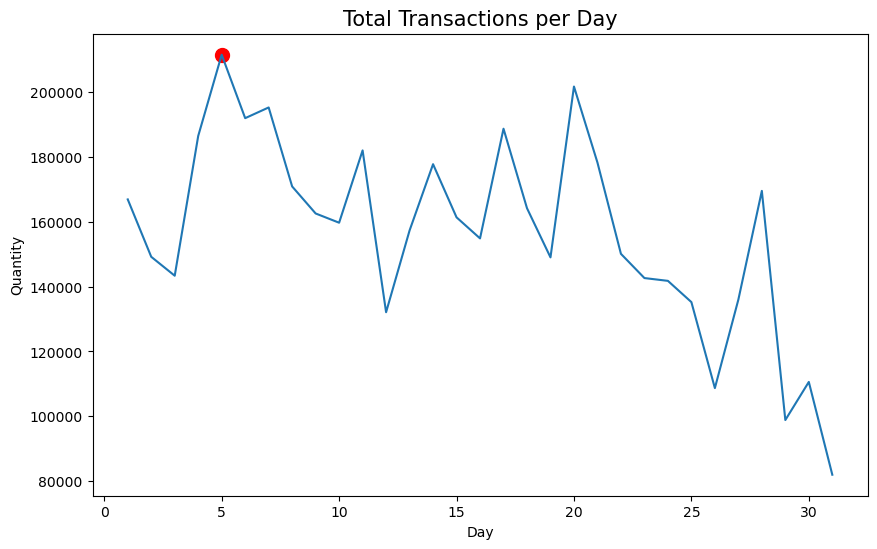

In [463]:
# Mark the hightes purchased day 
plt.figure(figsize=(10,6))
sns.lineplot(x='day',y='quantity',data=day_quantity)

# Find the highest point
max_quantity = day_quantity['quantity'].max()
max_day = day_quantity[day_quantity['quantity'] == max_quantity]['day'].values[0]

# Color the highest point
plt.scatter(max_day, max_quantity, color='red', s=100)  

# Add titel and labels
plt.title('Total Transactions per Day',size=15)
plt.xlabel('Day')
plt.ylabel('Quantity')

In [464]:
# 3.2.5 Season
# 3.2.5.1 Total quantity by season
# Difine a function to classify the season
def season(df,column):
     df.loc[df[column].isin([12, 1, 2]), 'season'] = 'winter'
     df.loc[df[column].isin([3, 4, 5]), 'season'] = 'spring'
     df.loc[df[column].isin([6, 7, 8]), 'season'] = 'summer'
     df.loc[df[column].isin([9, 10, 11]), 'season'] = 'autumn'
   
     return df

In [465]:
# Call the season function
data=season(original, 'month')

In [466]:
data.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,total_order_value,description,year,month,weekday,day,season
0,536370,21791,24,2010-12-01 08:45:00,1.25,u12583,France,30.00,VINTAGE HEADS AND TAILS CARD GAME,2010,12,Wed,1,winter
1,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.30,WOODEN FRAME ANTIQUE WHITE,2010,12,Wed,1,winter
2,536378,21929,10,2010-12-01 09:37:00,1.95,u14688,United Kingdom,19.50,JUMBO BAG PINK VINTAGE PAISLEY,2010,12,Wed,1,winter
3,536381,37444A,1,2010-12-01 09:41:00,2.95,u15311,United Kingdom,2.95,YELLOW BREAKFAST CUP AND SAUCER,2010,12,Wed,1,winter
4,536381,15056BL,2,2010-12-01 09:41:00,5.95,u15311,United Kingdom,11.90,EDWARDIAN PARASOL BLACK,2010,12,Wed,1,winter


In [467]:
# Seasons with tatal_quantity
season_quantity=data.groupby('season')[['quantity']].sum().reset_index().sort_values(by='quantity', ascending=False)

In [468]:
# Check the result
season_quantity.head()

,season,quantity
0,autumn,1741890
2,summer,1102621
3,winter,1030294
1,spring,986980


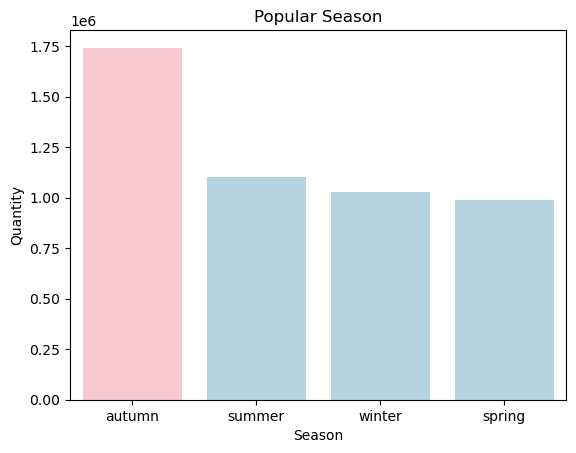

In [469]:
# Show the popular season
colors = ['pink' if season == 'autumn' else 'lightblue' for season in season_quantity['season']]

sns.barplot(x='season',y='quantity',data=season_quantity,palette=colors)
plt.title('Popular Season')
plt.xlabel('Season')
plt.ylabel('Quantity')
plt.show()

In [470]:
# 3.2.5.2 Top 3 products by sales for each season
# Extract products and sales by season
season_stockcode=data.groupby(['season','stock_code'])[['quantity']].sum().reset_index().sort_values(by=['season','quantity'], ascending=False)

In [471]:
season_stockcode.head()

,season,stock_code,quantity
9591,winter,22197,11661
11184,winter,84077,11447
11558,winter,85123A,9174
8941,winter,21212,9070
11544,winter,85099B,7976


In [472]:
# Filter specific stock codes within each season
autumn_stockcode = season_stockcode[season_stockcode['season'] == 'autumn'].head(3)
spring_stockcode = season_stockcode[season_stockcode['season'] == 'spring'].head(3)
summer_stockcode = season_stockcode[season_stockcode['season'] == 'summer'].head(3)
winter_stockcode = season_stockcode[season_stockcode['season'] == 'winter'].head(3)

In [473]:
# Check one of season with the top 3 stock_code 
autumn_stockcode

,season,stock_code,quantity
1688,autumn,23084,18673
906,autumn,22197,17659
2453,autumn,84077,16040


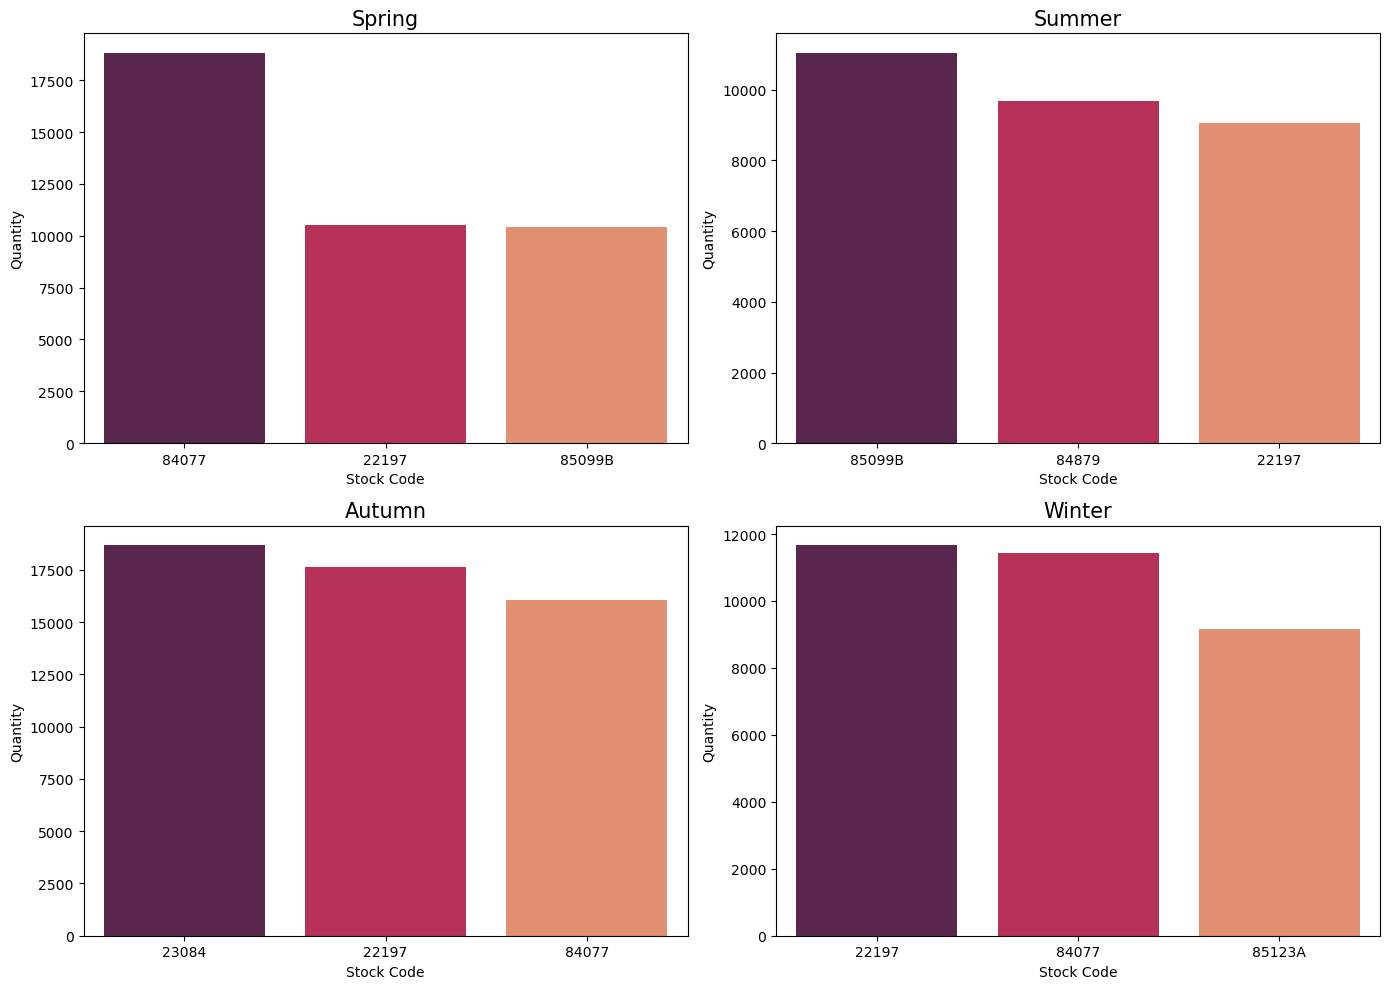

In [474]:
# Show the popular stock code in each season
plt.figure(figsize=(14, 10))

# Barchart of spring
plt.subplot(2, 2, 1)
sns.barplot(x='stock_code', y='quantity', data=spring_stockcode, palette='rocket')
plt.title('Spring',size=15)
plt.xlabel('Stock Code')
plt.ylabel('Quantity')

# Barchart of Summer
plt.subplot(2, 2, 2)
sns.barplot(x='stock_code', y='quantity', data=summer_stockcode, palette='rocket')
plt.title('Summer',size=15)
plt.xlabel('Stock Code')
plt.ylabel('Quantity')

# Barchart of Autumn
plt.subplot(2, 2, 3)
sns.barplot(x='stock_code', y='quantity', data=autumn_stockcode, palette='rocket')
plt.title('Autumn',size=15)
plt.xlabel('Stock Code')
plt.ylabel('Quantity')

# Barchart of Winter
plt.subplot(2, 2, 4)
sns.barplot(x='stock_code', y='quantity', data=winter_stockcode, palette='rocket')
plt.title('Winter',size=15)
plt.xlabel('Stock Code')
plt.ylabel('Quantity')

# Adjust the layout of the subplots
plt.tight_layout()

# Display the plot
plt.show()

In [475]:
# The specified list of stock codes
stockcode_list=['84077','22197','85099B','84879','22197','23084','85123A']

In [476]:
# Filter records where stock_code is in the specified list
description=original[original['stock_code'].isin(stockcode_list)]

In [477]:
# Select only the stock_code and description columns and remove duplicates
description[['stock_code','description']].drop_duplicates()

,stock_code,description
319,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
1500,85123A,CREAM HANGING HEART T-LIGHT HOLDER
1533,22197,POPCORN HOLDER
1562,84879,ASSORTED COLOUR BIRD ORNAMENT
2856,85099B,JUMBO BAG RED RETROSPOT
47126,23084,RABBIT NIGHT LIGHT


In [478]:
# 3.2.5.3 Total orders and total sales by season
# Aggregate season with total orders and total sales 
season_segment = original.groupby('season').agg(
    num_orders=('invoice', 'nunique'),
    total_order_value=('total_order_value', 'sum')).reset_index()

In [479]:
# Define the season order
season_order=['spring', 'summer', 'autumn', 'winter']

In [480]:
# Set the season column as a categorical type with the specified order
season_segment['season']=pd.Categorical(season_segment['season'],categories=season_order,ordered=True)

In [481]:
# Check the result
season_segment=season_segment.sort_values('season').reset_index(drop=True)

In [482]:
season_segment

,season,num_orders,total_order_value
0,spring,3933,1640916.261
1,summer,3931,1798108.181
2,autumn,6206,2991331.381
3,winter,4094,1782948.440


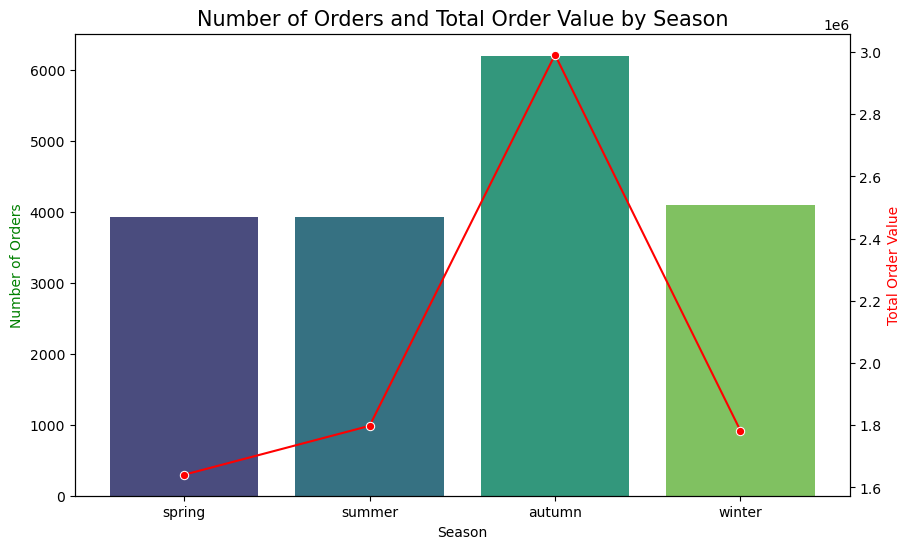

In [483]:
# Create Dual-Axis Chart
fig, ax1=plt.subplots(figsize=(10,6))

# Create a second y-axis that shares the same x-axis
ax2=ax1.twinx()

# Plot the number of orders with a bar plot on the first y-axis
sns.barplot(x='season',y='num_orders',data=season_segment,palette='viridis',ax=ax1)

# Plot the total order value with a line plot on the second y-axis
sns.lineplot(x='season',y='total_order_value',data=season_segment,sort=False,color='red',marker='o',ax=ax2)

# Set the title and the labels of the plot
ax1.set_title('Number of Orders and Total Order Value by Season',fontsize=15)
ax1.set_xlabel('Season')
ax1.set_ylabel('Number of Orders',color='green')
ax2.set_ylabel('Total Order Value',color='red')

# Display the plot
plt.show()

### Some initial insights：

- Most customers come from the UK, followed by Germany, France, and Ireland.
- If we examine the average sales price by country, we observe that Lebanon has the highest average sales price.
- The data for most countries shows skewness in the price feature, particularly with many high outliers.
- Popcorn containers are bestsellers in every season, followed by WWII gliders.
- Most transactions occur in November, which is related to the holiday season.
- There are no transactions on Saturdays, which may be related to whether the ordering system is open.

# 4 Cohort Analysis

## 4.1 Define Cohorts

In [484]:
# Change the type of invoice_date
original['invoice_date'] = pd.to_datetime(original['invoice_date'])

In [485]:
# Define a function that will parse the date
def get_day(x):
    return datetime(x.year, x.month, x.day)

In [486]:
# Create InvoiceDay column
original['InvoiceDay'] = original['invoice_date'].apply(get_day)

In [487]:
# Group by customer_id and select the InvoiceDay value
grouping=original.groupby('customer_id')['InvoiceDay']

In [488]:
# Assign a minimum InvoiceDay value to the dataset
original['CohortDay']=grouping.transform('min')

In [489]:
original.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,total_order_value,description,year,month,weekday,day,season,InvoiceDay,CohortDay
0,536370,21791,24,2010-12-01 08:45:00,1.25,u12583,France,30.00,VINTAGE HEADS AND TAILS CARD GAME,2010,12,Wed,1,winter,2010-12-01,2010-12-01
1,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.30,WOODEN FRAME ANTIQUE WHITE,2010,12,Wed,1,winter,2010-12-01,2010-12-01
2,536378,21929,10,2010-12-01 09:37:00,1.95,u14688,United Kingdom,19.50,JUMBO BAG PINK VINTAGE PAISLEY,2010,12,Wed,1,winter,2010-12-01,2010-12-01
3,536381,37444A,1,2010-12-01 09:41:00,2.95,u15311,United Kingdom,2.95,YELLOW BREAKFAST CUP AND SAUCER,2010,12,Wed,1,winter,2010-12-01,2010-12-01
4,536381,15056BL,2,2010-12-01 09:41:00,5.95,u15311,United Kingdom,11.90,EDWARDIAN PARASOL BLACK,2010,12,Wed,1,winter,2010-12-01,2010-12-01


## 4.2 Data Collection and Preparation

In [490]:
# Define a function to get date
def get_date_int(df,column):
    year=df[column].dt.year
    month=df[column].dt.month
    day=df[column].dt.day
    return year,month,day

In [491]:
# Get the integers for date parts from the 'InvoiceDay' column
invoice_year,invoice_month,invoice_day=get_date_int(original,'InvoiceDay')

In [492]:
# Get the integers for date parts from the 'CohortDay' column
cohort_year,cohort_month,cohort_day=get_date_int(original,'CohortDay')

## 4.3 Calculate Cohort Metrics

In [493]:
# Calculate difference in years
years_diff=invoice_year-cohort_year

In [494]:
# Calculate difference in months
months_diff=invoice_month-cohort_month

In [495]:
# Calculate difference in days
days_diff=invoice_day-cohort_day

In [496]:
# Extract the difference in days from all previous values
original['CohortIndex']=years_diff*12+months_diff+1

In [497]:
original.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,total_order_value,description,year,month,weekday,day,season,InvoiceDay,CohortDay,CohortIndex
0,536370,21791,24,2010-12-01 08:45:00,1.25,u12583,France,30.00,VINTAGE HEADS AND TAILS CARD GAME,2010,12,Wed,1,winter,2010-12-01,2010-12-01,1
1,536373,82494L,6,2010-12-01 09:02:00,2.55,u1785,United Kingdom,15.30,WOODEN FRAME ANTIQUE WHITE,2010,12,Wed,1,winter,2010-12-01,2010-12-01,1
2,536378,21929,10,2010-12-01 09:37:00,1.95,u14688,United Kingdom,19.50,JUMBO BAG PINK VINTAGE PAISLEY,2010,12,Wed,1,winter,2010-12-01,2010-12-01,1
3,536381,37444A,1,2010-12-01 09:41:00,2.95,u15311,United Kingdom,2.95,YELLOW BREAKFAST CUP AND SAUCER,2010,12,Wed,1,winter,2010-12-01,2010-12-01,1
4,536381,15056BL,2,2010-12-01 09:41:00,5.95,u15311,United Kingdom,11.90,EDWARDIAN PARASOL BLACK,2010,12,Wed,1,winter,2010-12-01,2010-12-01,1


In [498]:
# Creat'CohortMonth' column
original['CohortMonth'] = original['CohortDay'].dt.to_period('M')

In [499]:
# Creat a loaded a groupby object as grouping DataFrame 
grouping=original.groupby(['CohortMonth','CohortIndex'])

In [500]:
# Count the number of uniqe values per customer_id
cohort_data=grouping['customer_id'].apply(pd.Series.nunique).reset_index()

## 4.4 Analyze and Visualize

In [501]:
# Creat a pivot
cohort_counts=cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='customer_id')

In [502]:
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,882.0,320.0,284.0,336.0,315.0,350.0,317.0,305.0,311.0,346.0,329.0,441.0,232.0
2011-01,413.0,88.0,111.0,96.0,133.0,118.0,104.0,99.0,123.0,135.0,152.0,49.0,NaN
2011-02,381.0,71.0,71.0,108.0,103.0,92.0,97.0,102.0,93.0,115.0,26.0,NaN,NaN
2011-03,450.0,65.0,112.0,87.0,101.0,75.0,118.0,104.0,125.0,40.0,NaN,NaN,NaN
2011-04,299.0,63.0,61.0,63.0,59.0,68.0,63.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,55.0,49.0,49.0,60.0,65.0,75.0,26.0,NaN,NaN,NaN,NaN,NaN
2011-06,241.0,42.0,38.0,64.0,56.0,78.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,186.0,32.0,38.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,170.0,34.0,41.0,42.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [503]:
# Select the first column and store it to cohort_sizes
cohort_sizes=cohort_counts.iloc[:,0]

In [504]:
# Divide the cohort count by cohort sizes along the rows
retention=cohort_counts.divide(cohort_sizes,axis=0)*100

In [505]:
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,100.0,36.281179,32.199546,38.095238,35.714286,39.682540,35.941043,34.580499,35.260771,39.229025,37.301587,50.000000,26.303855
2011-01,100.0,21.307506,26.876513,23.244552,32.203390,28.571429,25.181598,23.970944,29.782082,32.687651,36.803874,11.864407,NaN
2011-02,100.0,18.635171,18.635171,28.346457,27.034121,24.146982,25.459318,26.771654,24.409449,30.183727,6.824147,NaN,NaN
2011-03,100.0,14.444444,24.888889,19.333333,22.444444,16.666667,26.222222,23.111111,27.777778,8.888889,NaN,NaN,NaN
2011-04,100.0,21.070234,20.401338,21.070234,19.732441,22.742475,21.070234,26.086957,7.357860,NaN,NaN,NaN,NaN
2011-05,100.0,19.366197,17.253521,17.253521,21.126761,22.887324,26.408451,9.154930,NaN,NaN,NaN,NaN,NaN
2011-06,100.0,17.427386,15.767635,26.556017,23.236515,32.365145,9.543568,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,100.0,17.204301,20.430108,22.580645,27.419355,11.290323,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,100.0,20.000000,24.117647,24.705882,12.352941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


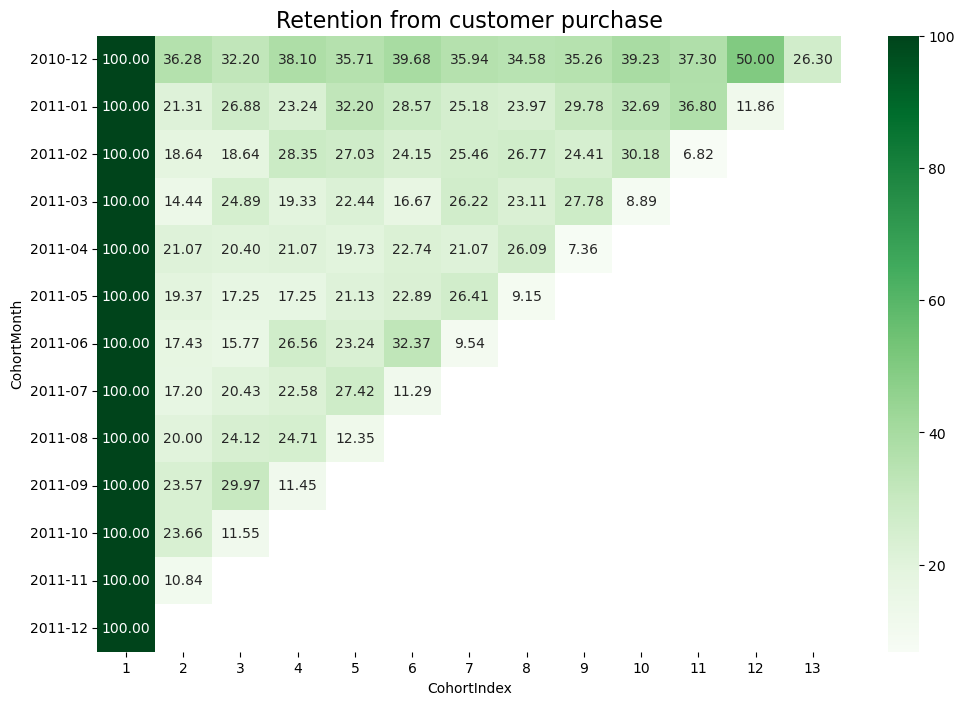

In [506]:
# Creat the heatmap
plt.figure(figsize=(12,8))

sns.heatmap(retention, annot=True, fmt='.2f', cmap='Greens')

plt.title('Retention from customer purchase', fontsize=16)
plt.show()

## 4.5 Interpret Results

- Customers who placed orders in December 2010 had the highest retention rates, with a notable retention rate 11 months later.
- The retention rates for customers from early 2011, for example, from January 2011 to April 2011, showed a significant decline.
- Customers who made their first purchase in December 2011 saw a significant drop. Compared to customers who made purchases in other months, these customers had the lowest retention rate one month later.
- Overall, there was a general downward trend in customer retention rates over time

# 5. RFM Analysis

## 5.1 Data Prepairation

In [507]:
# Aggregate only customer id will lose some customers' purchase
agg_functions = {
    'quantity': 'sum',
    'invoice': 'nunique',  # calculate the number of unique invoices
    'total_order_value': 'sum',
    'invoice_date': ['min', 'max']  # Get the earliest and latest purchase times
}

In [508]:
original.groupby('customer_id').agg(agg_functions).reset_index().shape

(4321, 6)

In [509]:
# Find the losed customers' purchase
grouped = original.groupby(['customer_id', 'country']).agg(agg_functions).reset_index()

In [510]:
# Rename columns
grouped.columns = ['customer_id', 'country', 'total_quantity', 'total_invoice', 'total_order_value', 'first_purchase', 'last_purchase']

In [511]:
# Check the result
grouped.head()

,customer_id,country,total_quantity,total_invoice,total_order_value,first_purchase,last_purchase
0,u12347,Iceland,2458,7,4310.00,2010-12-07 14:57:00,2011-12-07 15:52:00
1,u12348,Finland,2332,4,1437.24,2010-12-16 19:09:00,2011-09-25 13:13:00
2,u12349,Italy,630,1,1457.55,2011-11-21 09:51:00,2011-11-21 09:51:00
3,u1235,Norway,196,1,294.40,2011-02-02 16:01:00,2011-02-02 16:01:00
4,u12352,Norway,388,5,1125.28,2011-02-16 12:33:00,2011-11-03 14:37:00


In [512]:
len(grouped)

4328

## 5.2 Calculate RFM Metrics

In [513]:
# Aggregate the RFM values for all customers, without considering the country
rfm_combined = grouped.groupby('customer_id').agg({
    'last_purchase': lambda x: (pd.to_datetime('2012-01-01') - x.max()).days,  # recency
    'total_invoice': 'sum',  # frequency
    'total_order_value': 'sum'  # monetary
}).rename(columns={
    'last_purchase': 'Recency',
    'total_invoice': 'Frequency',
    'total_order_value': 'MonetaryValue'
}).reset_index()

In [514]:
# Check the result
rfm_combined.head()

,customer_id,Recency,Frequency,MonetaryValue
0,u12347,24,7,4310.00
1,u12348,97,4,1437.24
2,u12349,40,1,1457.55
3,u1235,332,1,294.40
4,u12352,58,5,1125.28


In [515]:
# Check the distribution
rfm_combined.describe()

,Recency,Frequency,MonetaryValue
count,4321.000000,4321.000000,4321.000000
mean,114.578338,4.203657,1900.787841
std,100.412547,7.512656,8211.285579
min,22.000000,1.000000,2.900000
25%,39.000000,1.000000,301.720000
50%,72.000000,2.000000,654.670000
75%,165.000000,5.000000,1608.100000
max,395.000000,202.000000,277460.420000


#### Notation
- These values represent the number of days since the last purchase, with a wide range from 22 days to 395 days. Generally, this is acceptable, indicating that some customers have purchased recently while others have not purchased for a long time.
- The purchase frequency ranges from 1 to 202, showing that some customers made only one purchase while others made many purchases. The large standard deviation indicates that the distribution of purchase frequency is uneven, with a few customers having particularly high purchase frequencies.
- The spending amount ranges from 2.9 to 277460.42, with a wide span. The mean and standard deviation suggest that a few customers have very high spending amounts, which raises the average.

## 5.3 Customer Segmentation - KMeans

In [516]:
# 5.3.1 Exploring the Data
# Get the RFM Values
df_rfm=rfm_combined[['Recency','Frequency','MonetaryValue']]

In [517]:
# Check the result
df_rfm.head()

,Recency,Frequency,MonetaryValue
0,24,7,4310.00
1,97,4,1437.24
2,40,1,1457.55
3,332,1,294.40
4,58,5,1125.28


In [518]:
# Check the distribution
df_rfm.describe()

,Recency,Frequency,MonetaryValue
count,4321.000000,4321.000000,4321.000000
mean,114.578338,4.203657,1900.787841
std,100.412547,7.512656,8211.285579
min,22.000000,1.000000,2.900000
25%,39.000000,1.000000,301.720000
50%,72.000000,2.000000,654.670000
75%,165.000000,5.000000,1608.100000
max,395.000000,202.000000,277460.420000


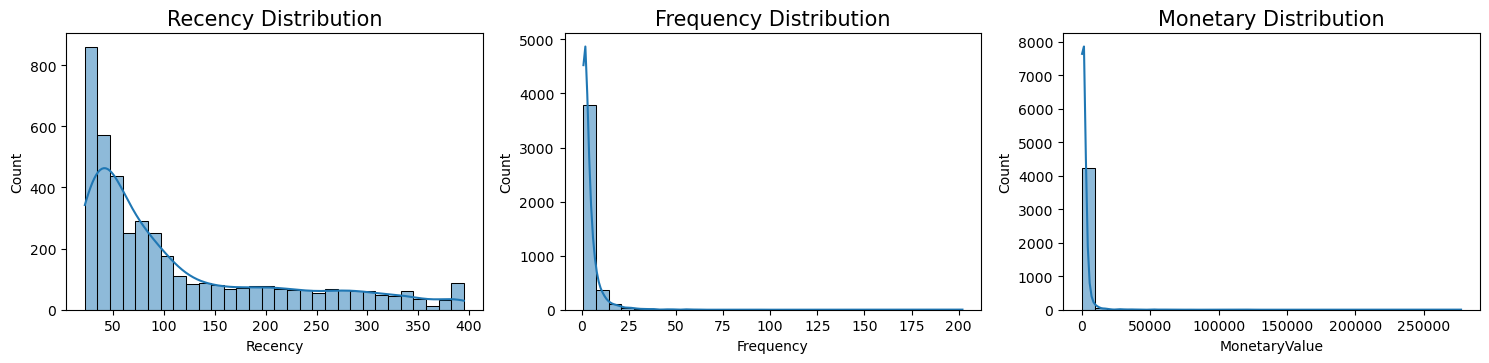

In [519]:
# Visualize the distribution of data
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(15, 10))

# Plot the distribution of the 'Recency' variable
plt.subplot(3, 3, 1)
sns.histplot(df_rfm['Recency'], bins=30, kde=True)
plt.title('Recency Distribution',size=15)

# Plot the distribution of the 'Frequency' variable
plt.subplot(3, 3, 2)
sns.histplot(df_rfm['Frequency'], bins=30, kde=True)
plt.title('Frequency Distribution',size=15)

# Plot the distribution of the 'MonetaryValue' variable
plt.subplot(3, 3, 3)
sns.histplot(df_rfm['MonetaryValue'], bins=30, kde=True)
plt.title('Monetary Distribution',size=15)

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Display the plot
plt.show()

In [520]:
# 5.3.2 Pre-processing the Data
# Perform a log transformation of the data to unskew the data
df_log = np.log1p(df_rfm)

In [521]:
# Check the distribution
df_log.describe()

,Recency,Frequency,MonetaryValue
count,4321.000000,4321.000000,4321.000000
mean,4.399826,1.336614,6.559216
std,0.831480,0.678165,1.245379
min,3.135494,0.693147,1.360977
25%,3.688879,0.693147,5.712808
50%,4.290459,1.098612,6.485658
75%,5.111988,1.791759,7.383430
max,5.981414,5.313206,12.533437


In [522]:
# Initialize a standard scaler
scaler=StandardScaler()

In [523]:
# Fit the scaler
scaler.fit(df_log)

StandardScaler()

In [524]:
# Scale and center the data
df_normalized=scaler.transform(df_log)

In [525]:
# Creat a pandas DataFrame of the processed data
df_processed=pd.DataFrame(df_normalized,index=df_rfm.index,columns=df_rfm.columns)

In [526]:
# Check the distribution
df_processed.describe().round(2)

,Recency,Frequency,MonetaryValue
count,4321.00,4321.00,4321.00
mean,0.00,0.00,-0.00
std,1.00,1.00,1.00
min,-1.52,-0.95,-4.17
25%,-0.86,-0.95,-0.68
50%,-0.13,-0.35,-0.06
75%,0.86,0.67,0.66
max,1.90,5.86,4.80


C:\Users\cheng\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



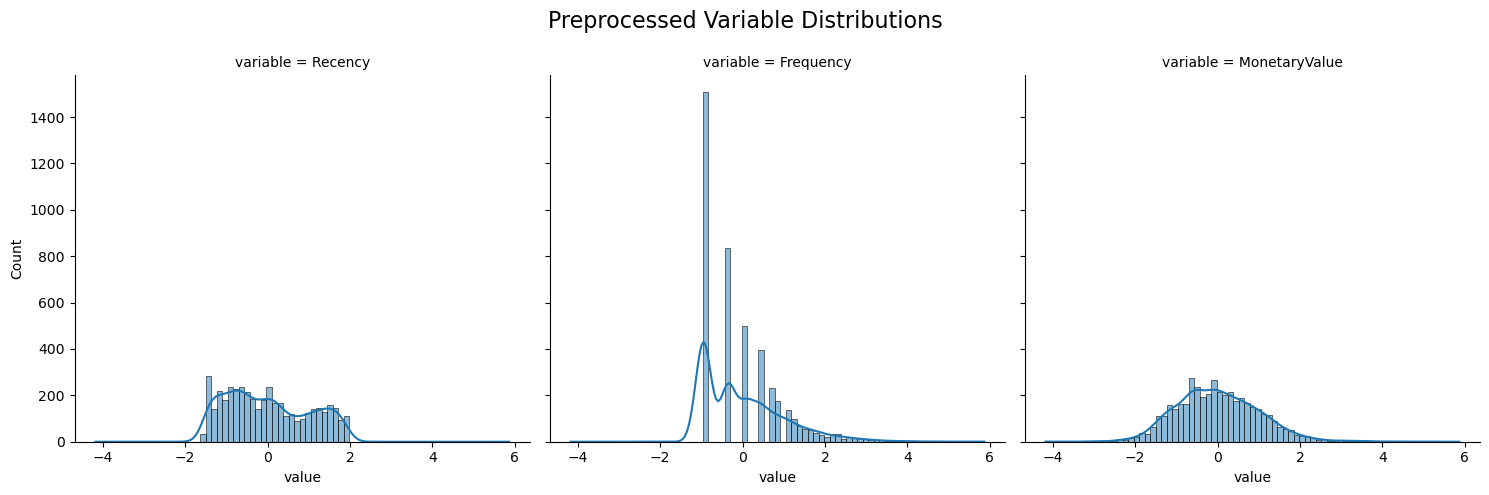

In [569]:
# Plot the distributions of the selected variables
# Melt the DataFrame to fit displot
df_melted = df_processed.melt()

# Use displot to create the plots
g = sns.displot(df_melted, col='variable', x='value', kind='hist', kde=True)

# Adjust layout
g.fig.subplots_adjust(top=0.85)

# Add title
g.fig.suptitle('Preprocessed Variable Distributions', fontsize=16)

# Show the plot
plt.show()

In [528]:
# 5.3.3 Choosing the Number of Clusters
# Set the maximum number of clusters to plot
max_clusters=10

In [529]:
# Initialize empty dictionary to store sum of  squared errors
sse={}

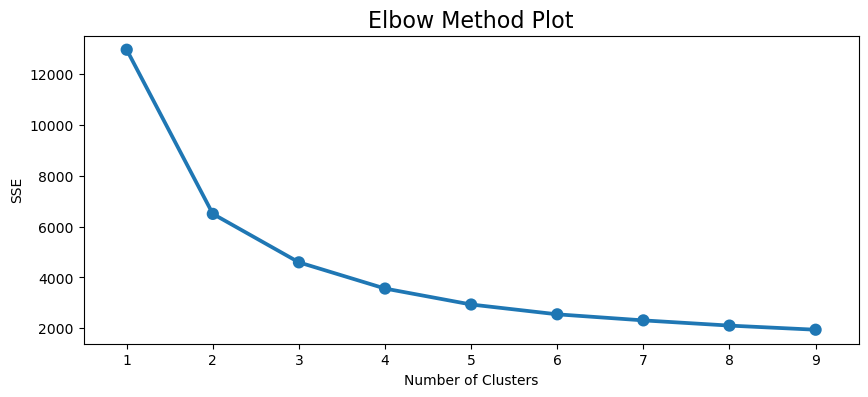

In [530]:
# Fit KMeans and calculate SSE for each k
for k in range(1,max_clusters):
    # Initialize KMeans with k clusters
    kmeans=KMeans(n_clusters=k,random_state=1)
    # Fit KMeans on the normalized dataset
    kmeans.fit(df_processed)
    # Assing sum of squared distances to k element of dictionary
    sse[k]=kmeans.inertia_

# Initialize a figure of set size
plt.figure(figsize=(10,4))

# Creat an elbow plot of SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()),y=list(sse.values()))

# Add labels to the plot
plt.title('Elbow Method Plot',fontsize=16)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

# Display the plot
plt.show()

In [531]:
# 5.3.4 Clustering the data
# 5.3.4.1 Cluster with k=2
# Choose the first number of clusters
k=2

In [532]:
# Initialize KMeans
kmeans_k2=KMeans(n_clusters=k, random_state=1)

In [533]:
# Fit k-means clustering on the normalized data set
kmeans_k2.fit(df_processed)

KMeans(n_clusters=2, random_state=1)

In [534]:
# Extract cluster labels
cluster_labels_k2=kmeans_k2.labels_

In [535]:
# Create a new DataFrame by adding a new cluster column to the original data
df_clustered_k2=df_rfm.assign(Cluster=cluster_labels_k2)

In [536]:
# Group the data by cluster
grouped_k2=df_clustered_k2.groupby(['Cluster'])

In [537]:
# Calculate average RFM values and segment sizes per cluster value
grouped_k2.agg({'Recency':'mean','Frequency':'mean','MonetaryValue':['mean','count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         158.7       1.6         470.3  2594
1          48.3       8.1        4049.4  1727

In [538]:
# 5.3.4.2 Cluster with k=3
# Choose another number of clusters 
k=3

In [539]:
# Initialize KMeans
kmeans=KMeans(n_clusters=3,random_state=1)

In [540]:
# Fit k-means clustering on the normalized data set
kmeans.fit(df_processed)

KMeans(n_clusters=3, random_state=1)

In [541]:
# Extract cluster labels
cluster_labels=kmeans.labels_

In [542]:
# Create a new DataFrame by adding a new cluster column to the original data
df_clustered=df_rfm.assign(Cluster=cluster_labels)

In [543]:
# Group the data by cluster
grouped=df_clustered.groupby(['Cluster'])

In [544]:
# Calculate average RFM values and segment sizes per cluster value
grouped.agg({'Recency':'mean','Frequency':'mean','MonetaryValue':['mean','count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          47.6      10.2        5327.4  1209
1         242.8       1.5         422.1  1328
2          64.5       2.2         679.3  1784

#### Comprehensive Analysis(Compare results)
- The first clustering analysis identifies two customer segments: one group with lower value but a larger number of customers (Cluster 0), and another with higher value but fewer customers (Cluster 1).

- The second clustering analysis identifies three customer segments: a group with the highest value (Cluster 0), a group with the lowest value (Cluster 1), and a group with medium value (Cluster 2). This more detailed segmentation allows for a better understanding of customer diversity and enables the implementation of different strategies for each segment.

#### The clustering analysis identifies three customer segments:

- Cluster 0: Highest RFM values (High Value)
- Cluster 1: Lowest RFM values (Low Value)
- Cluster 2: Moderate RFM values (Medium Value)

In [545]:
# 5.3.5 Inspecting the Clusters
# 5.3.5.a. Visualizing the Raw Values by Cluster
# Group the data by cluster and calculate
df_sizes=df_clustered.groupby(['Cluster'],as_index=False).size()

In [546]:
# Inspect the row counts
df_sizes

,Cluster,size
0,0,1209
1,1,1328
2,2,1784


In [547]:
# Calculate the mean of feature columns by cluster
df_means=df_clustered.groupby(['Cluster'])[df_rfm.columns].mean().reset_index()

In [548]:
df_means

,Cluster,Recency,Frequency,MonetaryValue
0,0,47.645988,10.170389,5327.409810
1,1,242.777861,1.458584,422.149489
2,2,64.506726,2.203475,679.288835


C:\Users\cheng\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



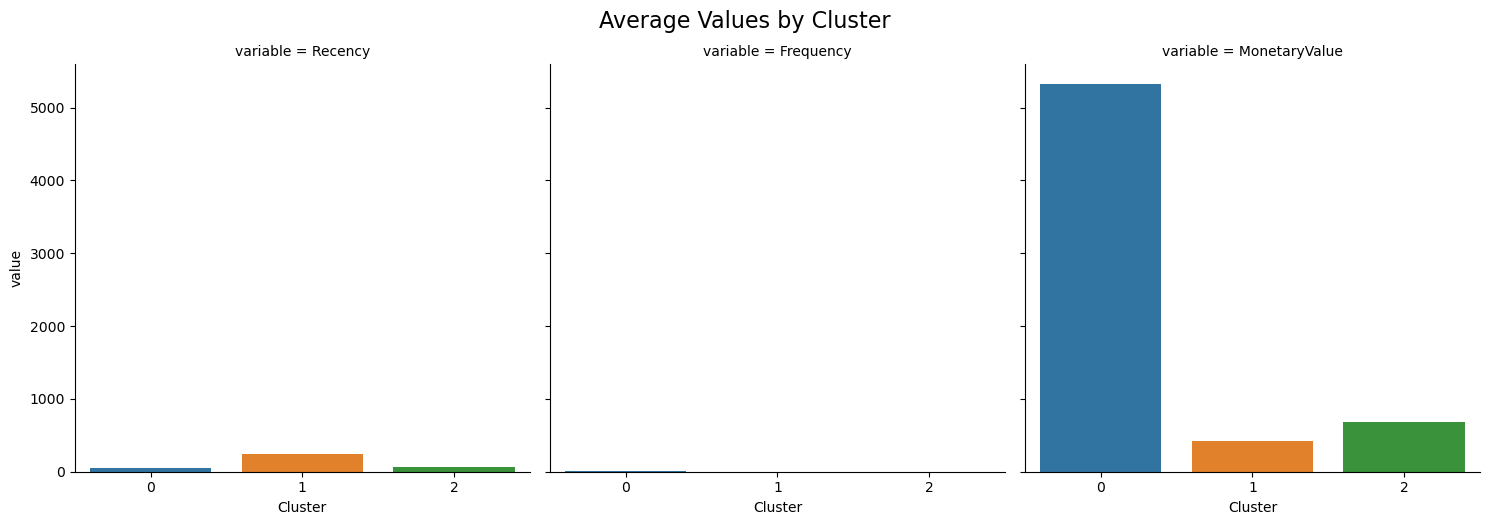

In [549]:
# Plot the distributions of the selected variables
sns.catplot(
    data=df_means.melt(id_vars='Cluster'),# Transform the data to enable plotting
    col='variable',
    x='Cluster',
    y='value',
    kind='bar',
)

# Add a title
plt.suptitle('Average Values by Cluster',y=1.04,fontsize=16)

plt.show()

In [550]:
# 5.3.5.b. Create a Snake Plot of the Clusters
# Assign cluster labels to processed DataFrame
df_processed_clustered=df_processed.assign(Cluster=cluster_labels)

In [551]:
df_processed_clustered.head()

,Recency,Frequency,MonetaryValue,Cluster
0,-1.420463,1.095476,1.453308,0
1,0.222691,0.402343,0.571747,2
2,-0.825435,-0.948945,0.583008,2
3,1.693943,-0.948945,-0.699375,1
4,-0.387653,0.671220,0.375399,0


In [552]:
# Melt the normalized DataFrame and reset the index
df_processed_melt=pd.melt(
    df_processed_clustered.reset_index(),
    # Assign the cluster labelss as the ID
    id_vars=['Cluster'],
    # Assign clustering variables as values
    value_vars=df_rfm.columns,
    # Name the variable and value
    var_name='Metric',
    value_name='Value',
)

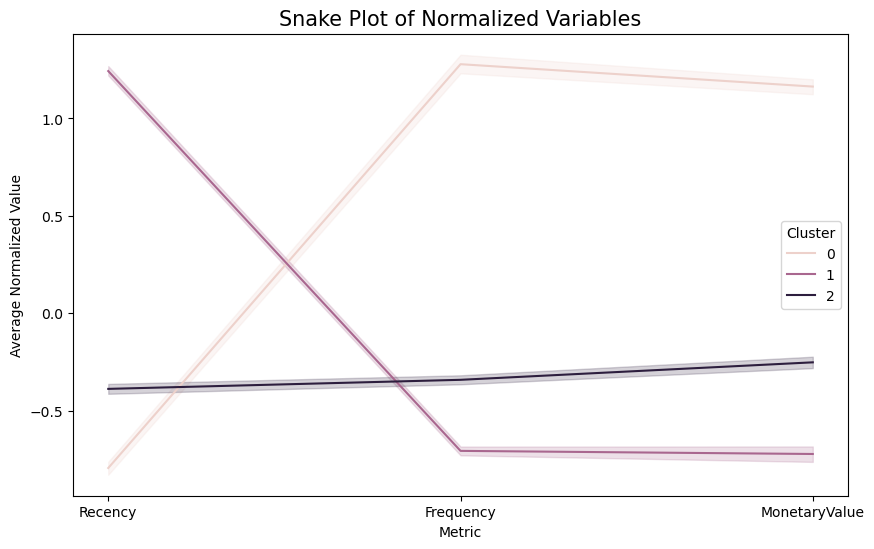

In [553]:
# change the figure size
plt.figure(figsize=(10,6))

# Add label and titles to the plot
plt.title('Snake Plot of Normalized Variables',fontsize=15)
plt.xlabel('Metric')
plt.ylabel('Average Normalized Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=df_processed_melt,x='Metric',y='Value',hue='Cluster')

plt.show()

In [554]:
# 5.3.5.c. Create a Heatmap of Relative Importances
# Calculate average RFM values for each cluster
cluster_avg=df_clustered.groupby(['Cluster'])[['Recency','Frequency','MonetaryValue']].mean()

In [555]:
cluster_avg

,Recency,Frequency,MonetaryValue
Cluster,,,
0,47.645988,10.170389,5327.409810
1,242.777861,1.458584,422.149489
2,64.506726,2.203475,679.288835


In [556]:
# Calculate average RFM values for the total customer population
population_avg=df_rfm.mean()

In [557]:
# Calculate relative importance of cluster's attribute value compared to population
relative_imp=cluster_avg/population_avg-1

In [558]:
relative_imp

,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.584162,1.419415,1.802738
1,1.118881,-0.653020,-0.777908
2,-0.437008,-0.475819,-0.642628


- This step calculates the variation of each cluster relative to the overall average. In other words, it assesses the increase or decrease in RFM values for each cluster compared to the overall average.
- Here, a relative importance greater than 0 indicates that the cluster's value for the respective metric is higher than the overall average，while less than 0 indicates it is lower than the overall average.

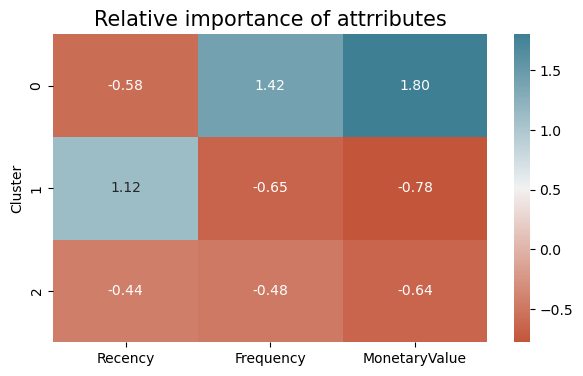

In [559]:
# change the figure size
plt.figure(figsize=(7,4))

# Plot the heatmap
sns.heatmap(data=relative_imp,annot=True,fmt='.2f',cmap=sns.diverging_palette(20,220,as_cmap=True))

# Add the plot title
plt.title('Relative importance of attrributes',fontsize=15)

plt.show()

#### Summary
The heatmap reveals clear differences in performance across RFM metrics among the different clusters.
- Cluster 0 performs better than the overall average on all three metrics, indicating that this cluster contains high-value customers.
- Cluster 1 has lower customer frequency and spending amounts but higher recency, which may represent low-value or potentially at-risk customers.
- Cluster 2's customers are below the overall average on all metrics, suggesting that this cluster's customers are less engaged in purchases.

# 5.4 Develop Marketing Strategies 

### 5.4.1 Cluster 0: High-Value Customers

#### 5.4.1.1 Characteristics
- Short Recency (recent purchase)
- high Frequency (purchase frequency)
- highest MonetaryValue (spending amount)

#### 5.4.1.2 Marketing Strategies
- Loyalty Programs: Design exclusive loyalty programs for high-value customers, such as point systems, membership discounts, and special offers to encourage continued purchases.
- Personalized Recommendations: Use purchase history to provide personalized product recommendations, highlighting related high-value items.
- Exclusive Events: Invite high-value customers to participate in time-limited sales, exclusive events, or new product launches to enhance engagement and loyalty.
- Feedback and Surveys: Regularly conduct customer satisfaction surveys to collect feedback, understand customer needs, and make product improvements to enhance satisfaction.

### 5.4.2 Cluster 1: Low-Value or Potentially At-Risk Customers

#### 5.4.2.1 Characteristics: 
- Higher Recency
- lower Frequency
- MonetaryValue.

#### 5.4.2.2 Marketing Strategies:
- Reactivation Campaigns: Use promotional activities, special discounts, or coupons to attract these customers back to make purchases. Send reminders through email or SMS.
- Increase Purchase Frequency: Implement incentive mechanisms, such as "buy one get one free" or "discounts on minimum purchase," to stimulate customers to increase their purchase frequency.
- Improve Customer Experience: Analyze reasons for customer churn, optimize product and service experiences, and increase purchase motivation.
- Establish Communication Channels: Maintain contact with customers through regular email marketing or social media interactions to understand their needs and preferences.

### 5.4.3 Cluster 2: Medium-Value Customers

#### 5.4.3.1 Characteristics: 
- Below average on all RFM metrics, indicating lower customer engagement.

#### 5.4.3.2 Marketing Strategies:
- Enhance Customer Engagement: Provide educational content, usage guides, or tutorials to help customers better understand the value and use of the products, increasing their engagement.
- Regular Promotions: Conduct regular promotional activities to attract customers to purchase more products, thereby increasing purchase frequency.
- Personalized Recommendations: Recommend suitable products based on customer purchase history and behavior data to spark interest in purchasing.
- Customer Education and Interaction: Host online webinars, product demos, or Q&A sessions to increase customer understanding and interest in the products, boosting purchase intent.

### 5.4.4 Additional Recommendations

- Continuous Monitoring: Regularly track the effectiveness of the marketing strategies implemented for each cluster. Use metrics such as conversion rates, customer retention rates, and overall sales performance to gauge success and make adjustments as needed.
- Cross-Cluster Strategies: Consider implementing cross-cluster strategies that can benefit multiple segments. For example, using customer feedback from Cluster 1 to improve overall customer experience can positively impact all clusters.
- Personalization Across Channels: Ensure that personalization strategies are applied consistently across all marketing channels (email, social media, website) to create a cohesive customer experience.
- Long-Term Customer Value: Focus on strategies that not only address current needs but also aim to increase the long-term value of customers by nurturing their relationship with the brand.
- 
By incorporating these suggestions, you can enhance the effectiveness of your marketing strategies and better address the diverse needs of each customer segment.